In [1]:
import torch
import time
import os
from torch.utils import data
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from model import Mnist_FCNN
from model import net
import torch.optim as optim
import torch
from torch import nn

In [2]:
def get_mnist_biased(batch_size, data_root, bias_portion):
    print('Building Biased Mnist dataloader...')
    ds = []
    train_dataset = datasets.MNIST(root=data_root, train=True, download=True,
                                    transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms. Normalize((0.1307,),(0.3081,)) 
                                    ]))   #得到原始Mnist数据集
    sampler = get_bin_sampler(train_dataset.targets, bias_portion, 10000) 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    ds.append(train_loader)

    test_dataset = datasets.MNIST(root=data_root, train=False, download=True,
                                    transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms. Normalize((0.1307,),(0.3081,)) 
                                    ]))   #得到原始Mnist数据集
    sampler = get_bin_sampler(test_dataset.targets, bias_portion, 2000) 
    test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=sampler)
    ds.append(test_loader)
    #all true
    true_dataset = datasets.MNIST(root=data_root, train=False, download=True,
                                    transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms. Normalize((0.1307,),(0.3081,)) 
                                    ]))   #得到原始Mnist数据集
    sampler = get_bin_sampler(test_dataset.targets, 0, 1000) 
    true_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=sampler)
    ds.append(true_loader)
    #all false
    false_dataset = datasets.MNIST(root=data_root, train=False, download=True,
                                    transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms. Normalize((0.1307,),(0.3081,)) 
                                    ]))   #得到原始Mnist数据集
    sampler = get_bin_sampler(test_dataset.targets, 100, 1000) 
    false_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=sampler)
    ds.append(false_loader)
    # ds = ds[0] if len(ds) == 1 else ds
    return ds

In [3]:
def get_bin_sampler(targets, bias_portion, num):
    class_count = torch.tensor(
        [(targets == t).sum() for t in torch.unique(targets, sorted=True)]) # 统计0 1两个class的样本总数
    sample_num = class_count[0] + class_count[1]
    class_weights = (sample_num)/class_count 
    class_weights[0] *= bias_portion   
    class_weights[1] *= (100-bias_portion)
    for i in range(2, 10):
        class_weights[i] = 0
    sample_weights = torch.tensor([class_weights[t] for t in targets])
    sampler = WeightedRandomSampler(sample_weights, num)
    return sampler

In [4]:
def test_data(data_loader):    
    loader = data_loader
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 8, 5
    for batch_idx, (data, target) in enumerate(loader):
        figure.add_subplot(rows, cols, batch_idx+1)
        plt.title(target.numpy())
        plt.axis("off")
        plt.imshow(data.squeeze(), cmap="gray")
        if batch_idx >= 39:
            break
    plt.show()

In [5]:
def acc(model, val_loader):
    model.eval()
    total_corr = 0
    for i, (data, target) in enumerate(val_loader):
        output = model(data)
        pred = output.max(1).indices
        print("pred:" + str(pred)) 
        print("target:" + str(target))
        if(pred == target):
            total_corr += 1    
    acc = total_corr / len(data)
    return acc   

In [6]:
# def train(bias_portion: int):
#     lr = 0.02 # learning rate
#     wd = 0.0005 # weight decay
#     epochs = 3 # number of epochs to train 
#     batch_size = 256 # input batch size for training
#     log_interval = 10000 # how many batches to wait before logging training status
#     test_interval = 3 #how many epochs to wait before another test
    
#     train_loader, test_loader, true_loader, false_loader = get_mnist_biased(batch_size=1, data_root='data', bias_portion = bias_portion)
#     model = net()
# #     optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
# #     criterion = torch.nn.CrossEntropyLoss()
# #     model.train()
# #     loss_list = []
# #     for epoch in range(epochs):
# #         running_loss = 0
# #         for data, target in train_loader:
# #             optimizer.zero_grad()
# #             output = model(data)
# #             loss = criterion(output, target)
# #             loss.backward()
# #             optimizer.step()            
# #             running_loss += loss.item()
# #             print(loss.item())
            
# #         loss_list.append(running_loss)
# #     plt.plot(loss_list)
# #     plt.xlabel('epochs')
# #     plt.ylabel('Crossentropy Loss')
# #     plt.show()
    
# #     print(acc(model, test_loader))
# #     print(acc(model, true_loader))
# #     print(acc(model, false_loader))

#     # optimizer
#     optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
#     critirion = torch.nn.BCEWithLogitsLoss()
#     model.train()
#     best_acc = 0
#     t_begin = time.time()
#     # training loop
#     for epoch in range(epochs):
#         running_loss = 0
#         for batch_idx, (data, target) in enumerate(train_loader):
#             indx_target = target.clone()
#             print(indx_target)
            
#             optimizer.zero_grad()
#             output = model(data).squeeze(0)
#             print(output)
#             loss = critirion(output.float(), target.float())
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#         print(running_loss)

    
        

In [7]:
def train(bias_portion: int, logdir='log/default.pt'):
    # Hyper Parameters
    lr = 0.02 # learning rate
    wd = 0.0005 # weight decay
    epochs = 3 # number of epochs to train 
    batch_size = 256 # input batch size for training
    log_interval = 10000 # how many batches to wait before logging training status
    test_interval = 3 #how many epochs to wait before another test
    
    train_loader, test_loader, true_loader, false_loader = get_mnist_biased(batch_size=1, data_root='data', bias_portion = bias_portion)
    test_data(train_loader)
    model = Mnist_FCNN()

    # optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    critirion = nn.CrossEntropyLoss()
    best_acc = 0
    t_begin = time.time()
    # training loop
    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            indx_target = target.clone()
            optimizer.zero_grad()
            output = model(data)
            print(indx_target)
            print(output)
            loss = critirion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0 and batch_idx > 0:
                pred = output.max(1).indices
                correct = pred.eq(indx_target).sum()
                acc = correct * 1.0 / len(data)
                print('Train Epoch: {} [{:>5d}/{}] Loss: {:.6f} Acc: {:.4f} lr: {:.2e}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    loss.data, acc, optimizer.param_groups[0]['lr']))
        if (epoch+1) % test_interval == 0:
            model.eval()
            test_loss = 0
            correct = 0
            for data, target in test_loader:
                indx_target = target.clone()
                with torch.no_grad():
                    output = model(data)
                    pred = output.max(1).indices
                    test_loss += critirion(output, target)
                    correct += pred.eq(indx_target).sum()
            test_loss = test_loss / len(test_loader)
            acc = 100. * correct / len(test_loader.dataset)
            print('Epoch: {}/{}  Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                epoch+1, epochs, test_loss, correct, len(test_loader.dataset), acc))
            if acc > best_acc:  ## save the best model
                if os.path.exists(logdir):  # 如果文件存在
                    os.remove(logdir)
                torch.save(model, logdir)
                best_acc = acc
    # training loop ends
    print("\n====================== Bias portion: {}% ========================".format(bias_portion))
    print('Elapse: {:.2f}s. Model accuracy: {:.3f}%. Saved at: {}'.format(time.time()-t_begin, best_acc, logdir))
    print("==============================================================\n")

Building Biased Mnist dataloader...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


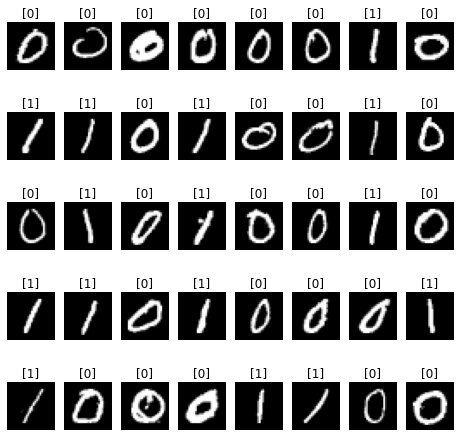

tensor([1])
tensor([[ 0.0612,  0.0250, -0.0012,  0.1724, -0.0255, -0.0329, -0.0790, -0.1735,
         -0.0325, -0.0807]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[-0.0389,  0.1859, -0.0133, -0.0343, -0.0915, -0.2060,  0.0563, -0.0586,
          0.0254, -0.1438]], grad_fn=<AddmmBackward>)
tensor([1])
tensor([[ 0.0213,  0.4020, -0.0301,  0.0725, -0.1288, -0.1140, -0.0925, -0.1460,
         -0.0621, -0.0335]], grad_fn=<AddmmBackward>)
tensor([1])
tensor([[ 0.1279,  0.6203, -0.0125,  0.0829, -0.1545, -0.1143, -0.1394, -0.2478,
         -0.1418, -0.1479]], grad_fn=<AddmmBackward>)
tensor([1])
tensor([[ 0.1201,  1.6512, -0.1972,  0.0176, -0.2396, -0.3433, -0.3000, -0.4397,
         -0.2342, -0.3302]], grad_fn=<AddmmBackward>)
tensor([1])
tensor([[ 0.2892,  4.2810, -0.4666, -0.0803, -0.5325, -0.9104, -0.5906, -1.0724,
         -0.6723, -0.7782]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[ 0.7465,  3.4844, -0.4666, -0.2543, -0.6104, -0.8850, -0.5745, -0.7281,
         -0.5989, -0.6642

tensor([0])
tensor([[ 6.8738e+02, -6.0117e+02, -7.8992e+00, -1.4783e+01, -1.8187e+01,
         -4.7999e+00,  3.9581e-01, -7.9068e+00, -5.3946e+00, -1.3984e+01]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[-75.6180, 131.2596,  -8.1934,  -6.6095,  -5.5321,  -5.0104,  -6.8202,
          -7.3309,  -7.0732,  -6.2144]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[ 6.2974e+02, -5.5045e+02, -7.5565e+00, -1.3466e+01, -1.7065e+01,
         -4.5380e+00,  2.0104e-01, -7.2267e+00, -4.9155e+00, -1.3053e+01]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[-48.8165,  85.5576,  -5.5161,  -4.3988,  -3.6861,  -3.0786,  -4.2617,
          -4.8566,  -4.6616,  -4.2231]], grad_fn=<AddmmBackward>)
tensor([1])
tensor([[-57.4227, 102.1390,  -6.7235,  -5.4086,  -4.5408,  -3.6682,  -5.1206,
          -5.8948,  -5.5937,  -5.2091]], grad_fn=<AddmmBackward>)
tensor([1])
tensor([[-96.9719, 167.5455, -10.4743,  -8.3863,  -7.0946,  -6.2229,  -8.6644,
          -9.3043,  -8.9767,  -8.0112]], grad_fn=<

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[na

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[na

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[-0.0219,  0.1040,  0.1461,  0.0566, -0.0603, -0.0168,  0.1381,  0.0810,
          0.0889, -0.1486]], grad_fn=<AddmmBackward>)
tensor([1])
tensor([[ 0.1675,  0.0811,  0.0990,  0.0621, -0.0674,  0.0371,  0.0737,  0.0201,
         -0.0131, -0.1321]], grad_fn=<AddmmBackward>)
tensor([1])
tensor([[ 2.9438e-01,  2.3023e-01,  1.3498e-01,  1.1612e-01, -8.1447e-02,
          5.3238e-02,  5.1470e-02, -9.4546e-02,  4.7885e-05, -1.1550e-01]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[ 0.5092,  0.3794, -0.0068,  0.0493, -0.1160, -0.1286, -0.0549,  0.0749,
         -0.1724, -0.1834]], grad_fn=<AddmmBackward>)
tensor([1])
tensor([[ 0.3616,  0.6549, -0.0453,  0.0573, -0.1377, -0.1846, -0.0636, -0.1147,
         -0.2438, -0.1385]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[ 3.1640,  1.2325, -0.2349, -0.1680, -0.2279, -0.5551, -0.4641, -0.2945,
         -0.4018, -0.7879]], grad_fn=<AddmmBackward>)
tensor([0])
tensor([[ 3.3527,  1.6558, -0.4379, -0.1652, -0.4770, -0.53

tensor([0])
tensor([[        inf,        -inf, -6.3339e+19,  4.0473e+19,  2.8022e+19,
          2.5735e+18,  5.4536e+18, -2.9483e+19,  2.3239e+18,  3.4084e+19]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]]

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, n

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan,

tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([1])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<AddmmBackward>)
tensor([0])
tensor([[nan, nan, nan, nan, nan, nan, nan,

KeyboardInterrupt: 

In [8]:
for i in range(70,80):
    train(bias_portion=50, logdir='log/1/{}.pt'.format(i))

In [ ]:
def test():   

    if not os.path.exists('log/1'):
        os.makedirs('log/1') #如果目录不存在则创建目录
    for i in range(600):
        logdir='log/1/{}.pt'.format(i)
        if not os.path.exists(logdir):  # 如果文件已存在就不再次训练了
            train(bias_portion=i%100, logdir=logdir)